## Importing SparkSession and loading our dataset

In [75]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
spark = SparkSession.builder.appName("diabetes").getOrCreate()

In [24]:
df = spark.read.csv("C:\\Users\\Asus\\Documents\\NEW Apprenticeship\\Big Data with PySpark\\Portfolio project_data\\statedesclbs_full.csv", header=True, inferSchema=True)

In [25]:
df.show(10)

+-----+----------+--------------------+--------------------+--------------------+-----------+--------------------+--------------+--------------+--------------------+--------------+--------+-------------+----+-------------+
|state|    county|             company|            sitename|             factype|       city|           unit_type|          scc1|        sector| process_description|pollutant_desc| emis_lb|emissions_uom|fuel|broadcategory|
+-----+----------+--------------------+--------------------+--------------------+-----------+--------------------+--------------+--------------+--------------------+--------------+--------+-------------+----+-------------+
|   CA| San Mateo|SUNQUEST PROPERTI...|SUNQUEST PROPERTI...|                null|   BRISBANE|        Unclassified|Waste Disposal|Waste Disposal|BRISBANE LANDFILL...|       Mercury|0.003591|           LB|null|           NA|
|   KY| Jefferson|Louisville Gas & ...|Louisville Gas & ...|Electricity Gener...| LOUISVILLE|Other bulk mate

## Printing the Schema of our dataset

In [26]:
df.printSchema()

root
 |-- state: string (nullable = true)
 |-- county: string (nullable = true)
 |-- company: string (nullable = true)
 |-- sitename: string (nullable = true)
 |-- factype: string (nullable = true)
 |-- city: string (nullable = true)
 |-- unit_type: string (nullable = true)
 |-- scc1: string (nullable = true)
 |-- sector: string (nullable = true)
 |-- process_description: string (nullable = true)
 |-- pollutant_desc: string (nullable = true)
 |-- emis_lb: double (nullable = true)
 |-- emissions_uom: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- broadcategory: string (nullable = true)



## Dropping unwanted columns

In [33]:
df1 = df.drop("company","sitename","factype","unit_type","sector","process_description","process_description","pollutant_desc","emissions_uom","fuel","broadcategory")
df1.show(10)

+-----+----------+-----------+--------------+--------+
|state|    county|       city|          scc1| emis_lb|
+-----+----------+-----------+--------------+--------+
|   CA| San Mateo|   BRISBANE|Waste Disposal|0.003591|
|   KY| Jefferson| LOUISVILLE|Waste Disposal|  0.0029|
|   CA|Stanislaus|    SJVAPCD|Waste Disposal|  0.0211|
|   CA|      Kern|EDWARDS AFB|Waste Disposal|  0.0021|
|   NC|Cumberland| Fort Bragg|Waste Disposal|   0.012|
|   LA|   Webster|    Sarepta|Waste Disposal|0.019739|
|   NC|    Gaston|    Belmont|Waste Disposal|  1.0E-4|
|   NC|    Gaston|    Belmont|Waste Disposal|  6.0E-5|
|   NY| Jefferson|     RODMAN|Waste Disposal|    0.01|
|   MN|    Ramsey| Saint Paul|Waste Disposal|1.267E-4|
+-----+----------+-----------+--------------+--------+
only showing top 10 rows



In [110]:
df11 = df1.dropna()
df11 = df1.describe().show()

+-------+-----+---------+---------+--------------------+------------------+
|summary|state|   county|     city|                scc1|           emis_lb|
+-------+-----+---------+---------+--------------------+------------------+
|  count|23891|    23891|    23886|               23899|             23899|
|   mean| null|     null|     null|                null|0.8163420367118884|
| stddev| null|     null|     null|                null| 7.924938913906276|
|    min|   AK|Abbeville|ABBEVILLE|Chemical Evaporation|          1.63E-15|
|    max|   WY|     Yuma|     luka|      Waste Disposal|            507.72|
+-------+-----+---------+---------+--------------------+------------------+



## Checking for missing values

In [111]:
from pyspark.sql.functions import isnan, when, count, col

In [114]:
df1.select([count(when(isnan(c),c)).alias(c) for c in df1.columns]).toPandas().head()

,state,county,city,scc1,emis_lb
0,0,0,0,0,0


#### No missing values in our dataset per the above result

## Renaming the column "scc1" to "pollution_type"

In [115]:
df11 = df1.withColumnRenamed("scc1","pollution_type")
df11.show(10)

+-----+----------+-----------+--------------+--------+
|state|    county|       city|pollution_type| emis_lb|
+-----+----------+-----------+--------------+--------+
|   CA| San Mateo|   BRISBANE|Waste Disposal|0.003591|
|   KY| Jefferson| LOUISVILLE|Waste Disposal|  0.0029|
|   CA|Stanislaus|    SJVAPCD|Waste Disposal|  0.0211|
|   CA|      Kern|EDWARDS AFB|Waste Disposal|  0.0021|
|   NC|Cumberland| Fort Bragg|Waste Disposal|   0.012|
|   LA|   Webster|    Sarepta|Waste Disposal|0.019739|
|   NC|    Gaston|    Belmont|Waste Disposal|  1.0E-4|
|   NC|    Gaston|    Belmont|Waste Disposal|  6.0E-5|
|   NY| Jefferson|     RODMAN|Waste Disposal|    0.01|
|   MN|    Ramsey| Saint Paul|Waste Disposal|1.267E-4|
+-----+----------+-----------+--------------+--------+
only showing top 10 rows



## Total pollution per pollution type

In [116]:
dfTP = df11.groupBy("pollution_type").sum("emis_lb")
dfTP.show()

+--------------------+------------------+
|      pollution_type|      sum(emis_lb)|
+--------------------+------------------+
|External Combusti...|10523.830574572212|
|      Waste Disposal|    258.1772662188|
|Internal Combusti...| 2085.406008318818|
| External Combustion|2.8452651073999995|
|Industrial Processes| 6612.858238258148|
|Chemical Evaporation|26.640982902001635|
+--------------------+------------------+



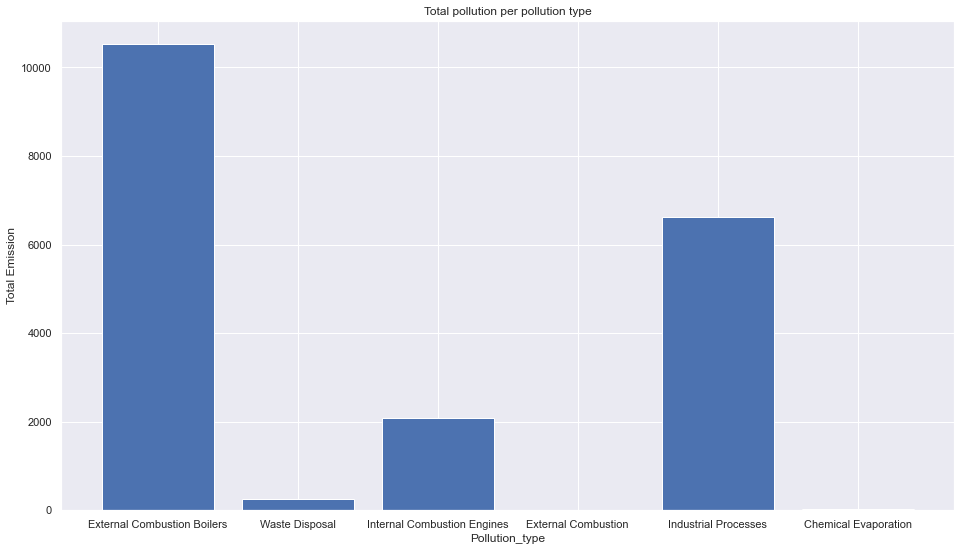

In [81]:
x = dfTP.toPandas()["pollution_type"].values.tolist()
y = dfTP.toPandas()["sum(emis_lb)"].values.tolist()    
plt.bar(x,y)
plt.title("Total pollution per pollution type")
plt.xlabel("Pollution_type")
plt.ylabel("Total Emission")
plt.show()

## Top 10 most polluted state

In [117]:
dfState = df11.groupBy("state").sum("emis_lb").orderBy(col("sum(emis_lb)").desc())
dfState.show(10)

+-----+------------------+
|state|      sum(emis_lb)|
+-----+------------------+
|   TX|2930.8011729858003|
|   PA| 1942.396941493003|
|   IN|1452.4571567399996|
|   CA|1176.3362286975291|
|   LA| 975.7269379466985|
|   OH| 974.1722518069997|
|   ND|      914.22970644|
|   WY| 745.8994532430002|
|   IL|   704.56074426461|
|   NC| 625.8312520159994|
+-----+------------------+
only showing top 10 rows



## Top 10 most polluted city

In [118]:
dfC = df11.groupBy("city").sum("emis_lb").orderBy(col("sum(emis_lb)").desc()).show(10)

+-------------+------------------+
|         city|      sum(emis_lb)|
+-------------+------------------+
|    PALMERTON| 987.0000000000002|
| Burns Harbor| 730.0925014510001|
|     Gramercy|       505.5830573|
|SLIPPERY ROCK|             443.6|
|     CLAYPOOL|387.79999999999995|
|    Underwood|          313.5023|
|       Aurora| 312.5733865561999|
|    FAIRFIELD|     280.455013254|
|    Waterford|            279.37|
|   HEALDSBURG|     279.000119105|
+-------------+------------------+
only showing top 10 rows



## Most polluted County

In [134]:
dfCo = df11.groupBy("county").sum("emis_lb").orderBy(col("sum(emis_lb)").desc()).show(1)

+------+------------------+
|county|      sum(emis_lb)|
+------+------------------+
|Carbon|1137.3770796700005|
+------+------------------+
only showing top 1 row

